# 당월 획득 점수 평균에 따른 이탈율 예측  

- 당월 획득 점수 평균 분포 : 0.00 ~ 1.00  
3분위로 나눠서 성적 분류 : 0.00 ~ 0.33 하위권 . 0.34 ~ 0.67 중위권 , 0.68 ~ 1.00 상위권  
----------------------------------------------------
- 활용데이터 : 수업시간 데이터와 동일하게 사용, 당월 획득 점수 평균에 따른 예측이기에 'correct_rate_avg' 제외  
X = score_data[['grade', 'tmon_pchrg_lrn_dcnt', 'acmlt_pchrg_lrn_dcnt', 'acmlt_bilclct_amt',   'learning_time_avg', 'media_action_cnt_sum', 'non_video_viewed_cnt_sum']]   
y = score_data['label']  
----------------------------
- 사용 예측 모델 : LGBM model 사용 , 데이터 불균형 맞춰주기 위해 SMOTE 적용  


In [1]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from lightgbm import plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib

In [2]:
churn_data = pd.read_csv("C:/Users/user/Downloads/code_kdt6/code_kdt6/data/churn_data.csv")
churn_data = churn_data.fillna(0)
churn_data = churn_data.drop(columns=['number'])

In [3]:
bins = [0.00, 0.33, 0.67, 1.0]
labels = ['하위권', '중위권', '상위권']
churn_data['score'] = pd.cut(churn_data['correct_rate_avg'], bins=bins, labels=labels, include_lowest=True)

grade_dict = {'G011' : 1,'G012' : 2,'G013' : 3,'G014' : 4,'G015' : 5,'G016' : 6 }
churn_data['grade'] = churn_data['grade_sect_cd'].apply(lambda x: grade_dict[x])

Before SMOTE - score 중위권 Value Counts:
label
0    11137
1       72
Name: count, dtype: int64
After SMOTE - score 중위권 Value Counts:
label
0    11137
1    11137
Name: count, dtype: int64
score 중위권 이탈 : 24, 미이탈 : 2779
score 중위권 accuracy: 0.9942918301819479
score 중위권 Precision: 0.5, Recall: 0.75, F1-Score: 0.6
---------------------------------------------------------------------


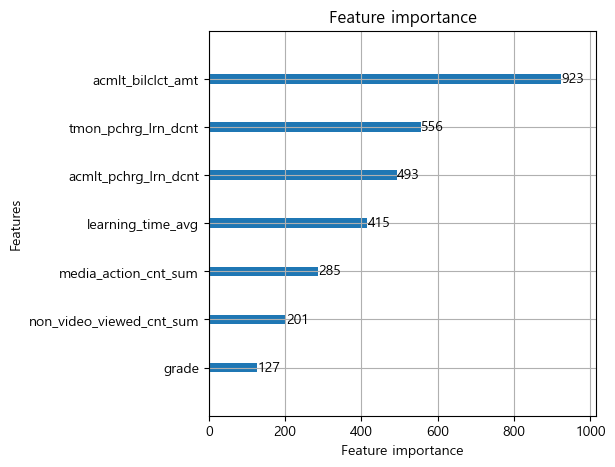

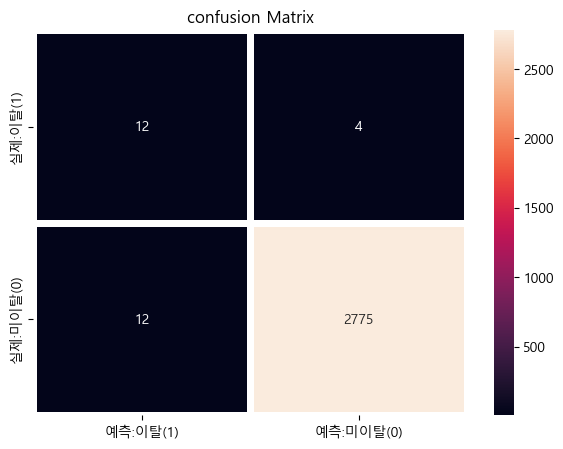

Before SMOTE - score 하위권 Value Counts:
label
0    2101
1     466
Name: count, dtype: int64
After SMOTE - score 하위권 Value Counts:
label
0    2101
1    2101
Name: count, dtype: int64
score 하위권 이탈 : 130, 미이탈 : 512
score 하위권 accuracy: 0.9439252336448598
score 하위권 Precision: 0.8153846153846154, Recall: 0.8983050847457628, F1-Score: 0.8548387096774194
---------------------------------------------------------------------


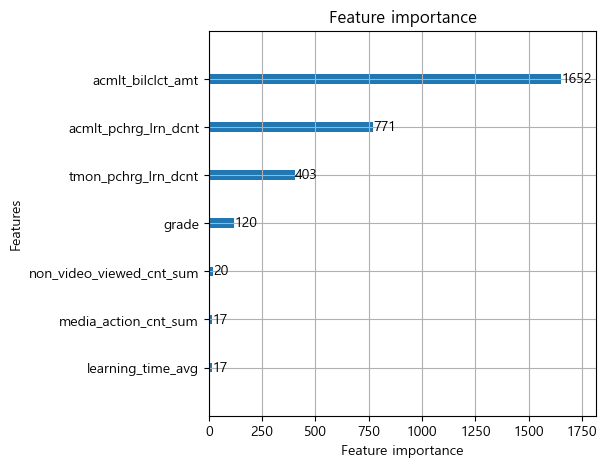

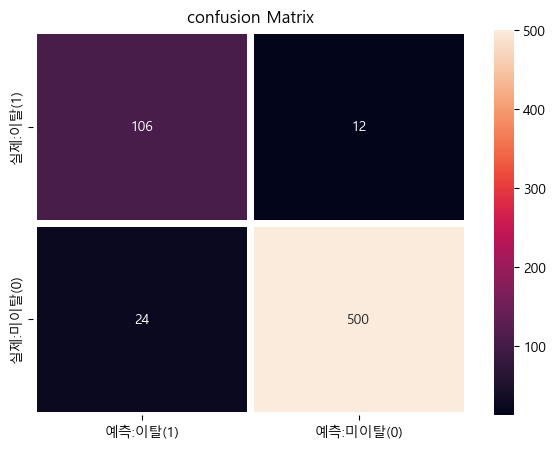

Before SMOTE - score 상위권 Value Counts:
label
0    34009
1      214
Name: count, dtype: int64
After SMOTE - score 상위권 Value Counts:
label
0    34009
1    34009
Name: count, dtype: int64
score 상위권 이탈 : 71, 미이탈 : 8485
score 상위권 accuracy: 0.9938055165965405
score 상위권 Precision: 0.4507042253521127, Recall: 0.6956521739130435, F1-Score: 0.547008547008547
---------------------------------------------------------------------


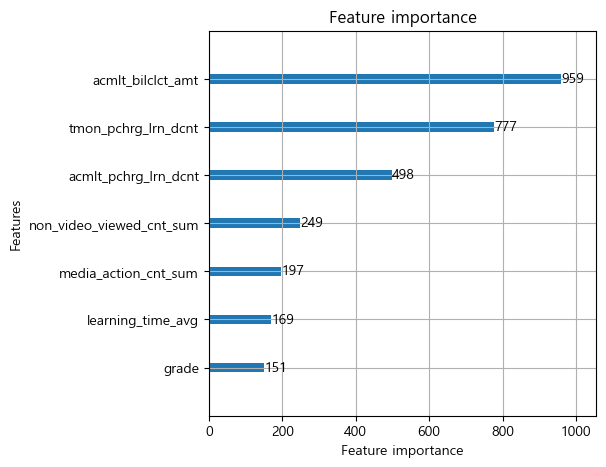

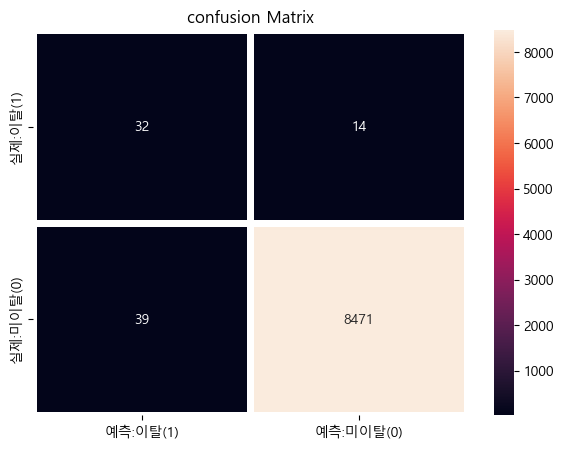

In [8]:
# 임계값 기본 

for score in churn_data['score'].unique():
    # 해당 성적 분위의 데이터 추출
    score_data = churn_data[churn_data['score'] == score]
    # 특성과 레이블 분리
    X = score_data[['grade', 'tmon_pchrg_lrn_dcnt', 'acmlt_pchrg_lrn_dcnt', 'acmlt_bilclct_amt', 'learning_time_avg', 'media_action_cnt_sum', 'non_video_viewed_cnt_sum']]
    y = score_data['label']
    
    # 학습 데이터와 테스트 데이터로 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 각 범위별 데이터 불균형 smote 적용
    X_train_over, y_train_over = SMOTE(random_state=0).fit_resample(X_train, y_train)
    
    print(f"Before SMOTE - score {score} Value Counts:\n{y_train.value_counts()}")
    print(f"After SMOTE - score {score} Value Counts:\n{y_train_over.value_counts()}")

    # 모델 생성 및 훈련
    lgbm_model = LGBMClassifier(random_state=0, verbose=-1)
    lgbm_model.fit(X_train_over, y_train_over)
    
    y_pred_lgbm = lgbm_model.predict(X_test)
    
    count_churn = (y_pred_lgbm == 1).sum()
    count_not_churn = (y_pred_lgbm == 0).sum()
    
    print(f"score {score} 이탈 : {count_churn}, 미이탈 : {count_not_churn}")
    
    accuracy = accuracy_score(y_test, y_pred_lgbm)
    print(f"score {score} accuracy: {accuracy}")
    
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred_lgbm, average='binary')
    print(f"score {score} Precision: {precision}, Recall: {recall}, F1-Score: {fscore}")
    print("---------------------------------------------------------------------")
    
    fig, ax = plt.subplots(figsize=(5,5))
    
    plot_importance(lgbm_model, ax=ax)
    plt.show()
    
    cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred_lgbm, labels = [1,0]),
    index = ['실제:이탈(1)', '실제:미이탈(0)'],
    columns = ['예측:이탈(1)', '예측:미이탈(0)'])

    plt.figure(figsize=(7,5))
    plt.title("confusion Matrix")
    sns.heatmap(cmtx, annot=True, fmt=".0f", linewidth=5)
    plt.show()

score 상위권 Precision: 0.4507042253521127, Recall: 0.6956521739130435, F1-Score: 0.547008547008547  

score 중위권 Precision: 0.5, Recall: 0.75, F1-Score: 0.6  

score 하위권 Precision: 0.8153846153846154, Recall: 0.8983050847457628, F1-Score: 0.8548387096774194  


- 하위권의 precision 과 re-call 값에 비해 상위권, 중위권의 precision, re-call 값이 낮음  
re-call값이 낮으면 이탈(1)을 미이탈(0)로 예측할 확률이 올라가 학생들의 이탈이 진행될 수 있음  
상위권, 중위권 학생들의 이탈을 막고 싶어 re-call 값을 올려 최적화 하기로 결정  
유저들 중 좋은 점수를 가지고 있는 학생들이 많아야 제품 이미지가 좋아지고, 다른 학생들의 유입율 올라감  

-----------------------
- 최적화 방법 : 임계값 재설정  
예측 확률이 0.5보다 크면 모델은 이탈(1) 로 예측하고, 그렇지 않으면 미이탈(0) 로 예측  
predict_proba 메서드를 사용하여 예측 확률을 얻은 다음, 이를 기반으로 임계값을 조정  
임계값 기본 0.5 에서 0.4로 조정, 이탈(1) 을 예측하는 값이 올라감  
Re-call은 실제 이탈 중에서 모델이 정확히 이탈로 예측한 비율, 임계값 감소할수록 더 많은 샘플을 이탈(1) 로 예측  
TP 증가, FP 증가, FN 감소  
re-call 값 증가, Precision 값 감소  


Before SMOTE - score 중위권 Value Counts:
label
0    11137
1       72
Name: count, dtype: int64
After SMOTE - score 중위권 Value Counts:
label
0    11137
1    11137
Name: count, dtype: int64
score 중위권 이탈 : 29, 미이탈 : 2774
score 중위권 accuracy: 0.9932215483410631
score 중위권 Precision: 0.4482758620689655, Recall: 0.8125, F1-Score: 0.5777777777777777
---------------------------------------------------------------------


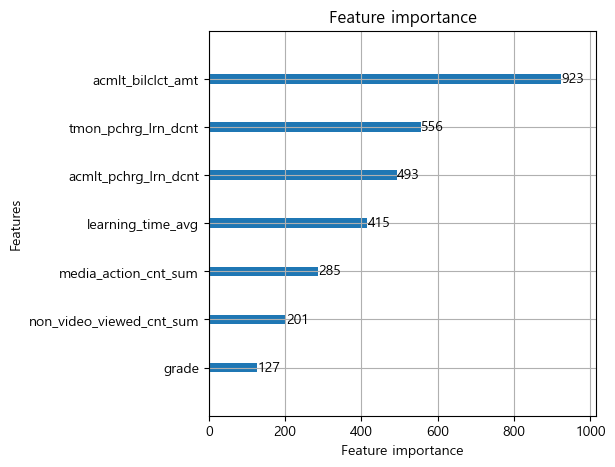

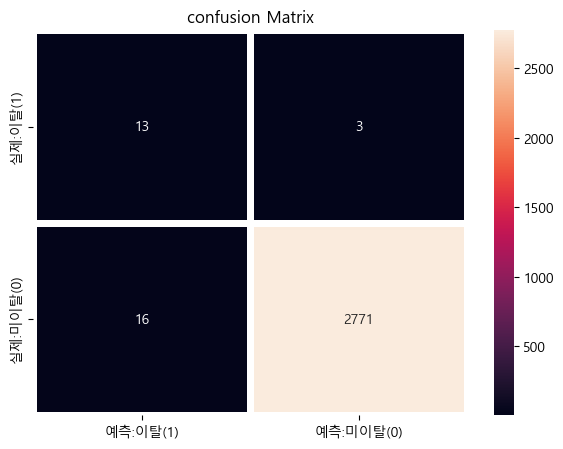

Before SMOTE - score 하위권 Value Counts:
label
0    2101
1     466
Name: count, dtype: int64
After SMOTE - score 하위권 Value Counts:
label
0    2101
1    2101
Name: count, dtype: int64
score 하위권 이탈 : 142, 미이탈 : 500
score 하위권 accuracy: 0.9439252336448598
score 하위권 Precision: 0.7887323943661971, Recall: 0.9491525423728814, F1-Score: 0.8615384615384616
---------------------------------------------------------------------


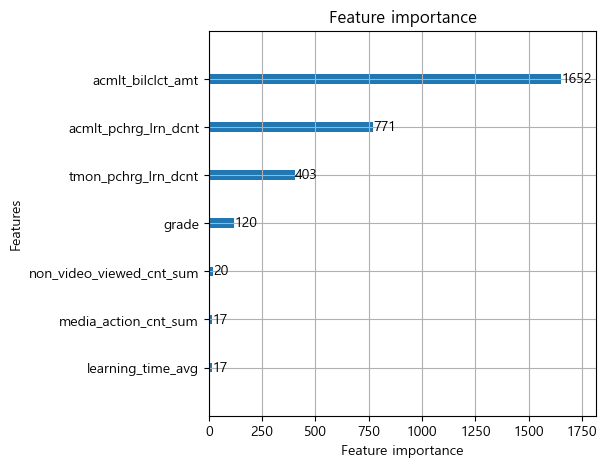

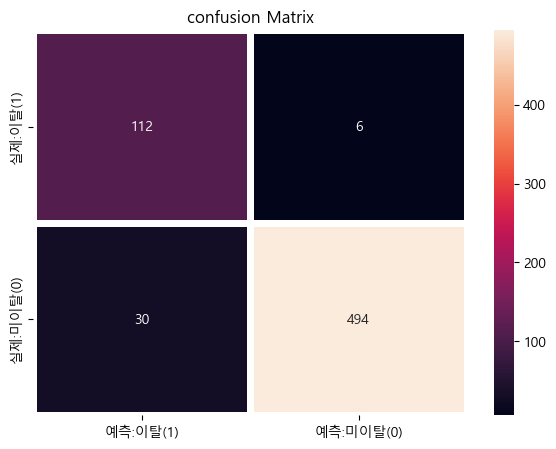

Before SMOTE - score 상위권 Value Counts:
label
0    34009
1      214
Name: count, dtype: int64
After SMOTE - score 상위권 Value Counts:
label
0    34009
1    34009
Name: count, dtype: int64
score 상위권 이탈 : 77, 미이탈 : 8479
score 상위권 accuracy: 0.9935717625058439
score 상위권 Precision: 0.44155844155844154, Recall: 0.7391304347826086, F1-Score: 0.5528455284552846
---------------------------------------------------------------------


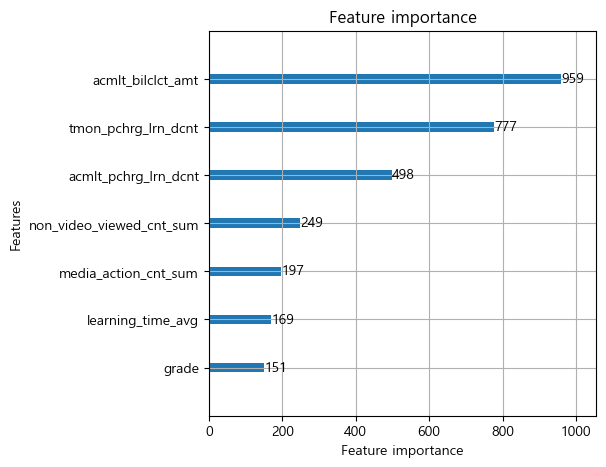

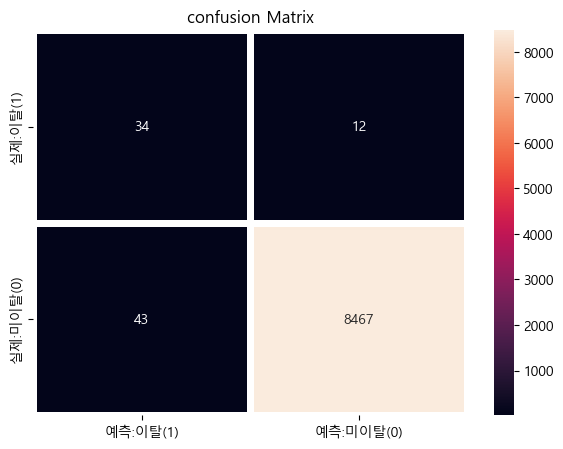

In [9]:
# 임계값 재설정

for score in churn_data['score'].unique():
    # 해당 성적 분위의 데이터 추출
    score_data = churn_data[churn_data['score'] == score]
    # 특성과 레이블 분리
    X = score_data[['grade', 'tmon_pchrg_lrn_dcnt', 'acmlt_pchrg_lrn_dcnt', 'acmlt_bilclct_amt', 'learning_time_avg', 'media_action_cnt_sum', 'non_video_viewed_cnt_sum']]
    y = score_data['label']
    
    # 학습 데이터와 테스트 데이터로 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 각 범위별 데이터 불균형 smote 적용
    X_train_over, y_train_over = SMOTE(random_state=0).fit_resample(X_train, y_train)
    
    print(f"Before SMOTE - score {score} Value Counts:\n{y_train.value_counts()}")
    print(f"After SMOTE - score {score} Value Counts:\n{y_train_over.value_counts()}")

    # 모델 생성 및 훈련
    lgbm_model = LGBMClassifier(random_state=0, verbose=-1)
    lgbm_model.fit(X_train_over, y_train_over)
    
    # Positive (1)의 예측 확률
    y_prob_positive_class = lgbm_model.predict_proba(X_test)[:, 1]
    
    # 임계값 재설정 (re-call 값 올리기 위해 임계값 감소 설정)
    custom_threshold = 0.4
    
    # 재설정 된 임계값을 기반으로 예측 수행
    y_pred_custom_threshold = (y_prob_positive_class >= custom_threshold).astype(int)
    
    count_churn = (y_pred_custom_threshold == 1).sum()
    count_not_churn = (y_pred_custom_threshold == 0).sum()
    
    print(f"score {score} 이탈 : {count_churn}, 미이탈 : {count_not_churn}")
    
    accuracy = accuracy_score(y_test, y_pred_custom_threshold)
    print(f"score {score} accuracy: {accuracy}")
    
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred_custom_threshold, average='binary')
    print(f"score {score} Precision: {precision}, Recall: {recall}, F1-Score: {fscore}")
    print("---------------------------------------------------------------------")
    
    fig, ax = plt.subplots(figsize=(5,5))
    plot_importance(lgbm_model, ax=ax)
    plt.show()
    
    cmtx1 = pd.DataFrame(
    confusion_matrix(y_test, y_pred_custom_threshold, labels = [1,0]),
    index = ['실제:이탈(1)', '실제:미이탈(0)'],
    columns = ['예측:이탈(1)', '예측:미이탈(0)'])

    plt.figure(figsize=(7,5))
    plt.title("confusion Matrix")
    sns.heatmap(cmtx1, annot=True, fmt=".0f", linewidth=5)
    plt.show()

- 임계값 조정 전 :  

score 상위권 Precision: 0.4507042253521127, Recall: 0.6956521739130435, F1-Score: 0.547008547008547  
score 상위권 이탈 : 71, 미이탈 : 8485  

score 중위권 Precision: 0.5, Recall: 0.75, F1-Score: 0.6  
score 중위권 이탈 : 24, 미이탈 : 2779  

score 하위권 Precision: 0.8153846153846154, Recall: 0.8983050847457628, F1-Score: 0.8548387096774194  
score 하위권 이탈 : 130, 미이탈 : 512  

TP : 32 , FP : 39 , FN : 14  

------------------------------------------------

- 임계값 조정 후 :  

score 상위권 Precision: 0.44155844155844154, Recall: 0.7391304347826086, F1-Score: 0.5528455284552846  
score 상위권 이탈 : 77, 미이탈 : 8479  

score 중위권 Precision: 0.4482758620689655, Recall: 0.8125, F1-Score: 0.5777777777777777  
score 중위권 이탈 : 29, 미이탈 : 2774  

score 하위권 Precision: 0.7887323943661971, Recall: 0.9491525423728814, F1-Score: 0.8615384615384616   
score 하위권 이탈 : 142, 미이탈 : 500  

TP : 34 , FP : 43 , FN : 12  

------------------------------------------------------
recall값이 올라가 이탈로 예측되는 학생 수가 높아진 것을 볼 수있음  
임계값 조정 후 하위권의 precision, recall 값은 여전히 높은편으로 모델이 이탈 유무를 예측하는데 높은 성능을 보이고 있음  
상위권, 중위권의 경우 recall 값이 증가함으로써 이탈할 학생을 예측해 프로모션 진행, 부가적인 서비스 등을 통해 이탈율을 줄일 수 있을 것으로 기대   